inspired by:

https://www.kaggle.com/code/robikscube/sentiment-analysis-python-youtube-tutorial

#### Imports

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import torch
import textwrap



In [16]:
import nltk

# Force re-download the punkt resource
nltk.download('punkt', force=True)
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('vader_lexicon')

# Check all available resources and their locations
print(nltk.data.path)

[nltk_data] Downloading package punkt to /Users/juliuseg/nltk_data...


['/Users/juliuseg/nltk_data', '/Users/juliuseg/DTU/CompTools/.venv/nltk_data', '/Users/juliuseg/DTU/CompTools/.venv/share/nltk_data', '/Users/juliuseg/DTU/CompTools/.venv/lib/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data']


[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/juliuseg/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/juliuseg/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Random hotel dataset

In [ ]:
# Read in data
df_full = pd.read_csv('data/reviews_hotel1.csv') # https://www.kaggle.com/datasets/nikitaryabukhin/reviewshotel?select=reviews_hotel1.csv
print(df_full.shape)
# Drop nan reviews
df_full = df_full[df_full['reviews.text'].notna()]
# Strip away the reviews that seem like outliers since only 5% of the data is not in this range.
df_full = df_full[df_full['reviews.rating'].isin([1.0, 2.0, 3.0, 4.0, 5.0])]
df = df_full.head(5000)
df = df.reset_index()
print(df.shape)


(35912, 4)
(5000, 5)


In [29]:
df.head()

,index,reviews.date,reviews.title,reviews.text,reviews.rating
0,0,2013-09-22T00:00:00Z,Good location away from the crouds,Pleasant 10 min walk along the sea front to th...,4.0
1,1,2015-04-03T00:00:00Z,Great hotel with Jacuzzi bath!,Really lovely hotel. Stayed on the very top fl...,5.0
2,2,2014-05-13T00:00:00Z,Lugnt l��ge,Ett mycket bra hotell. Det som drog ner betyge...,5.0
3,3,2013-10-27T00:00:00Z,Good location on the Lido.,We stayed here for four nights in October. The...,5.0
4,4,2015-03-05T00:00:00Z,������ ���������������,We stayed here for four nights in October. The...,5.0


In [30]:
# Combine title and review into one column:
df['Review'] = df['reviews.title'] + '\n' + df['reviews.text']
df.drop(columns=['reviews.title', 'reviews.text'], inplace=True)

# Rename the colomns for easier data replacement:
df.rename(columns={'reviews.rating': 'Rating'}, inplace=True)
df.head()

,index,reviews.date,Rating,Review
0,0,2013-09-22T00:00:00Z,4.0,Good location away from the crouds\nPleasant 1...
1,1,2015-04-03T00:00:00Z,5.0,Great hotel with Jacuzzi bath!\nReally lovely ...
2,2,2014-05-13T00:00:00Z,5.0,Lugnt l��ge\nEtt mycket bra hotell. Det som dr...
3,3,2013-10-27T00:00:00Z,5.0,Good location on the Lido.\nWe stayed here for...
4,4,2015-03-05T00:00:00Z,5.0,������ ���������������\nWe stayed here for fou...


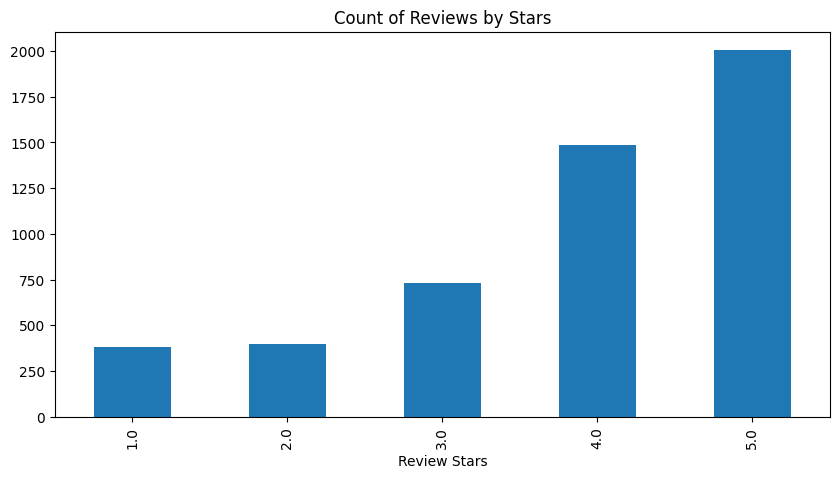

In [31]:
ax = df['Rating'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()



In [32]:
example = df['Review'][0]
print(example)

Good location away from the crouds
Pleasant 10 min walk along the sea front to the Water Bus. restaurants etc. Hotel was comfortable breakfast was good - quite a variety. Room aircon didn't work very well. Take mosquito repelant!


### Tokens

In [33]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['Good',
 'location',
 'away',
 'from',
 'the',
 'crouds',
 'Pleasant',
 '10',
 'min',
 'walk']

In [34]:
tagged = nltk.pos_tag(tokens) # See meanings here https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
tagged[:10]

[('Good', 'JJ'),
 ('location', 'NN'),
 ('away', 'RB'),
 ('from', 'IN'),
 ('the', 'DT'),
 ('crouds', 'NN'),
 ('Pleasant', 'NNP'),
 ('10', 'CD'),
 ('min', 'NN'),
 ('walk', 'NN')]

### Dictionary approach (VADER)

In [35]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()


In [36]:
temp = sia.polarity_scores(example)
print (example)
print (temp)

Good location away from the crouds
Pleasant 10 min walk along the sea front to the Water Bus. restaurants etc. Hotel was comfortable breakfast was good - quite a variety. Room aircon didn't work very well. Take mosquito repelant!
{'neg': 0.043, 'neu': 0.685, 'pos': 0.272, 'compound': 0.8924}


In [41]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Review']
    # if text is float print the index and the text
    if isinstance(text, float):
        print(row['index'], text)
        continue
    myid = row['index']
    res[myid] = sia.polarity_scores(text)

print(len(res))



  0%|          | 0/5000 [00:00<?, ?it/s]

184 nan
185 nan
885 nan
925 nan
1261 nan
1262 nan
1606 nan
1668 nan
1693 nan
1694 nan
1695 nan
1696 nan
1697 nan
1698 nan
1699 nan
1700 nan
1750 nan
1751 nan
1752 nan
1753 nan
1754 nan
1765 nan
1766 nan
1767 nan
1768 nan
1769 nan
1770 nan
1771 nan
1772 nan
1773 nan
1774 nan
1775 nan
1776 nan
1777 nan
1778 nan
1779 nan
1781 nan
1782 nan
1783 nan
1784 nan
1785 nan
1786 nan
1787 nan
1788 nan
1789 nan
1790 nan
1791 nan
1794 nan
1797 nan
2555 nan
2577 nan
2578 nan
2579 nan
2593 nan
2594 nan
2595 nan
2661 nan
2766 nan
2767 nan
2768 nan
3151 nan
3166 nan
3348 nan
3750 nan
3751 nan
3752 nan
3753 nan
3754 nan
3755 nan
3802 nan
4293 nan
4382 nan
4444 nan
4445 nan
4557 nan
4729 nan
4730 nan
4731 nan
4732 nan
4921


In [42]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'index'})
vaders = vaders.merge(df, how='left')

In [43]:
vaders.head()

,index,neg,neu,pos,compound,reviews.date,Rating,Review
0,0,0.043,0.685,0.272,0.8924,2013-09-22T00:00:00Z,4.0,Good location away from the crouds\nPleasant 1...
1,1,0.017,0.497,0.486,0.9872,2015-04-03T00:00:00Z,5.0,Great hotel with Jacuzzi bath!\nReally lovely ...
2,2,0.000,1.000,0.000,0.0000,2014-05-13T00:00:00Z,5.0,Lugnt l��ge\nEtt mycket bra hotell. Det som dr...
3,3,0.000,0.700,0.300,0.9719,2013-10-27T00:00:00Z,5.0,Good location on the Lido.\nWe stayed here for...
4,4,0.000,0.719,0.281,0.9643,2015-03-05T00:00:00Z,5.0,������ ���������������\nWe stayed here for fou...


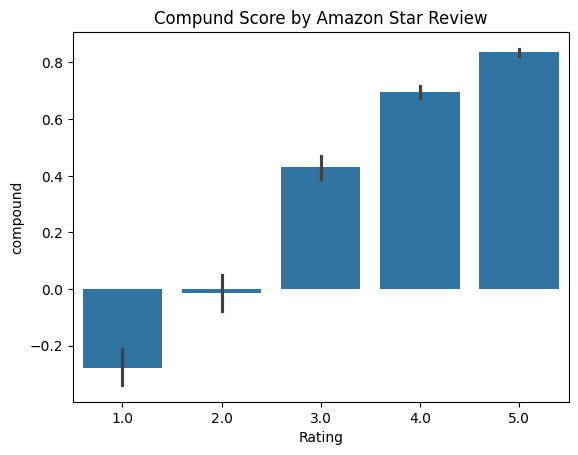

In [44]:
ax = sns.barplot(data=vaders, x='Rating', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()


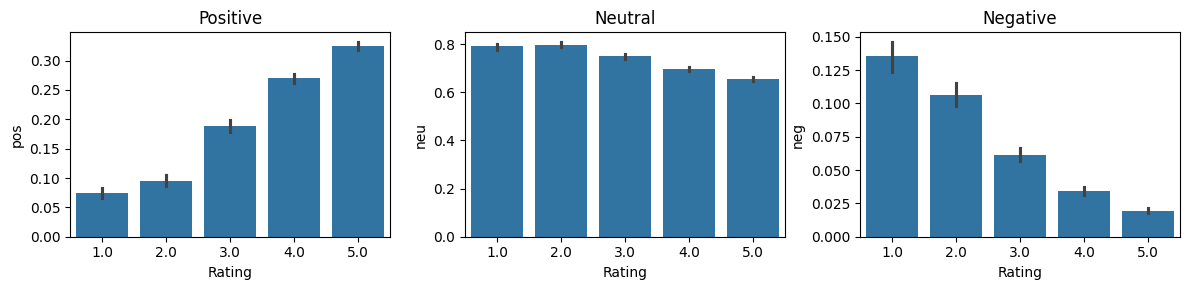

In [45]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Rating', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Rating', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Rating', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()



### Pretrained transformer model (Roberta)

In [46]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax



In [47]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# Because im using my mac m2 where metal is gpu framework (Like cuda for nvidia)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)
model.to(device)

mps


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [48]:
# VADER results on example for comparison
print(example)
print(sia.polarity_scores(example))

# Roberta
# Tokenize and move tensors to the same device as model
encoded_text = tokenizer(example, return_tensors="pt")
encoded_text = {k: v.to(device) for k, v in encoded_text.items()}

# Run inference safely on MPS
with torch.no_grad():
    output = model(**encoded_text)

# Move result to CPU for numpy operations
scores = output.logits[0].to("cpu").numpy()
scores = softmax(scores)

scores_dict = {
    'roberta_neg': scores[0],
    'roberta_neu': scores[1],
    'roberta_pos': scores[2]
}
print({k: round(float(v), 3) for k, v in scores_dict.items()})

Good location away from the crouds
Pleasant 10 min walk along the sea front to the Water Bus. restaurants etc. Hotel was comfortable breakfast was good - quite a variety. Room aircon didn't work very well. Take mosquito repelant!
{'neg': 0.043, 'neu': 0.685, 'pos': 0.272, 'compound': 0.8924}
{'roberta_neg': 0.041, 'roberta_neu': 0.157, 'roberta_pos': 0.801}


#### Function to use to do entire dataset

In [49]:
def polarity_scores_roberta(example):
    # Tokenize and move to correct device
    encoded_text = tokenizer(example, return_tensors="pt")
    encoded_text = {k: v.to(device) for k, v in encoded_text.items()}

    # Inference
    with torch.no_grad():
        output = model(**encoded_text)

    # Move back to CPU for numpy conversion
    scores = output.logits[0].to("cpu").numpy()
    scores = softmax(scores)

    # Convert to normal floats
    return {
        'roberta_neg': float(scores[0]),
        'roberta_neu': float(scores[1]),
        'roberta_pos': float(scores[2])
    }


In [51]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Review']
        # if text is float print the index and the text
        if isinstance(text, float):
            print("Skipped float value on: ",row['index'], text)
            continue
        myid = row['index']
        
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/5000 [00:00<?, ?it/s]

Broke for id 22
Skipped float value on:  184 nan
Skipped float value on:  185 nan
Skipped float value on:  885 nan
Skipped float value on:  925 nan
Skipped float value on:  1261 nan
Skipped float value on:  1262 nan
Skipped float value on:  1606 nan
Skipped float value on:  1668 nan
Skipped float value on:  1693 nan
Skipped float value on:  1694 nan
Skipped float value on:  1695 nan
Skipped float value on:  1696 nan
Skipped float value on:  1697 nan
Skipped float value on:  1698 nan
Skipped float value on:  1699 nan
Skipped float value on:  1700 nan
Skipped float value on:  1750 nan
Skipped float value on:  1751 nan
Skipped float value on:  1752 nan
Skipped float value on:  1753 nan
Skipped float value on:  1754 nan
Skipped float value on:  1765 nan
Skipped float value on:  1766 nan
Skipped float value on:  1767 nan
Skipped float value on:  1768 nan
Skipped float value on:  1769 nan
Skipped float value on:  1770 nan
Skipped float value on:  1771 nan
Skipped float value on:  1772 nan
Sk

In [54]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'index'})
results_df = results_df.merge(df, how='left')
results_df.columns

Index(['index', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'reviews.date', 'Rating',
       'Review'],
      dtype='object')

### Examples

In [55]:
q = results_df.query('Rating == 1') \
    .sort_values('roberta_pos', ascending=False)['Review'].values[0]

print(textwrap.fill(q, width=85))
    

UNJUSTIFIED Great Hotel! Great hotel! Held a business meeting there the last few
days. The staff was friendly, extremely helpful, and went out of their way to
accomodate us. The suites were outstanding, very comfortable and clean. The location
is awesome too, 1 minute walk to 2 restaurants, Longhorn Steak House and Cracker
Barrel in addition to a gas station and convenience store. The breakfast was
complimentary and very good, both hot and cold food. This will be my choice whenever
I visit Dublin in the future. Thanks La Quinta!


In [56]:
q = results_df.query('Rating == 1') \
    .sort_values('vader_pos', ascending=False)['Review'].values[0]

print(textwrap.fill(q, width=85))

Clean and Comfortable Serves a great continental breakfast and offers free Wi-Fi.


In [57]:
q = results_df.query('Rating == 5') \
    .sort_values('roberta_neg', ascending=False)['Review'].values[0]

print(textwrap.fill(q, width=85))


Stay away It was terrible. Would never stayhere agian. So bad i didnt even go back
for my 2nd night. Worst place i have ever staid at. Very nasty needs o be closed down


In [58]:

q = results_df.query('Rating == 5') \
    .sort_values('vader_neg', ascending=False)['Review'].values[0]

print(textwrap.fill(q, width=85))



sauberes DurchschnittsHotel Das Hotel war im Groen und Ganzen in Ordnung nur die
Umgebung mit der Baustelle war nicht so prickelnd
